In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details")
from code_comparison.solps_pp import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

from DLScommonTools import *
from wall_details import wall_details

set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2



# Read balance file

In [2]:
eqb = dict()


balancepath =  r"C:\Users\mikek\OneDrive\Project\DLS\from_david\2023-11-30 - New SPR45 balance file\balance.nc"

for sepadd in [0,9]:

    eqb[sepadd] = dict()

    for side in ["il", "ol"]: 
        eqb[sepadd][side] = unpackConfigurationMK(File =balancepath, 
                                                Type = side, sepadd=sepadd, resolution = 200)
        
        keys = list(eqb[sepadd][side].keys())
        for key in keys:
            
            if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
                eqb[sepadd][side].pop(key, None)
            
    # file_write(eqb, "equilibrium.pkl")

In [3]:
balancepath =  r"C:\Users\mikek\OneDrive\Project\DLS\from_david\2023-11-30 - New SPR45 balance file"

slc = self = SOLPScase(balancepath)

# Setup and run DLS

In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

In [8]:
cvar = "density"
design = "SPR45_new"

store = dict()

for sepadd in [0]:
    store[sepadd] = dict()
    for cvar in ["density", "impurity_frac", "power"]:
        store[sepadd][cvar] = dict()
        
        for side in ["il", "ol"]:
        # for side in ["il"]:
            d = eqb[sepadd][side].copy() # Load in single profile into dictionary "d"
            constants = constants_default.copy() # Set settings to default
            radios = radios_default.copy() # Set settings to default
            SparRange = np.linspace(0, d["S"][d["Xpoint"]], 10) # Solve at these parallel positions

            if "i" in side:
                constants["qpllu0"] = 1.1e9
            if "o" in side:
                constants["qpllu0"] = 2e9  
            

            results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)
            
            store[sepadd][cvar][side] = copy.deepcopy(results)

Solving...0...6...11...15...18...20...21...22...23...24...Complete in 20.7 seconds
Solving...0...28...48...60...67...71...73...74...75...Complete in 18.5 seconds
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 19.4 seconds
Solving...0...28...48...60...67...71...73...74...75...Complete in 18.0 seconds
Solving...0...6...11...15...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


18...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


20...21...22...23...24...Complete in 63.4 seconds
Solving...0...28...48...60...67...71...73...74...75...Complete in 41.8 seconds


In [9]:
file_write(store, "spr45_full.pkl")

In [5]:
store = file_read("spr45_full.pkl")

# Functions 

In [6]:
def make_dzones(side, zone, value = 1):
    """
    Make SOLPS result array where the front operational zone is marked by 1
    And all other cells are 0
    """

    sel = (slice(None,None), slc.g["sep"])
    R = slc.g["R"][sel]
    Z = slc.g["Z"][sel]
    Lpol = returnll(R,Z)
    
    loc = dict(ol = "outer", il = "inner")[side]

    df = pd.DataFrame()

    # Poloidal distances from target
    df["Lpol_inner"] = Lpol
    df["Lpol_outer"] = (Lpol[-1] - Lpol)  

    # Data array with the zones
    dzones = np.zeros_like(slc.g["R"])

    indices = np.array(df.query(f"Lpol_{loc} > {zone[0]} and Lpol_{loc} < {zone[1]}").index)
    dzones[indices, slice(slc.g["sep"], None)] = value

    return dzones


def get_zone(store, side, margin, cvar = None):
    
    sepadd = 0
    start = []
    end = []
    
    if cvar == None:
        list_cvars = ["density", "impurity_frac", "power"]
        
    else:
        list_cvars = [cvar]

    for i, cvar in enumerate(list_cvars):
        
        o = store[sepadd][cvar][side]
        crel = 1/o["crel"] if cvar == "power" else o["crel"]
        margin1 = abs((crel[0] - crel)/crel)
        margin2 = abs((crel[-1] - crel)/crel)

        x = o["SpolPlot"]
        lpar = o["Splot"]
        # ax.hlines(0.05, x[0], x[-1]*1.05, colors = "r", lw = 2, ls = "-", label = "5% fluctuation")
        start.append(x[np.where(margin1 > margin)[0][0]])
        end.append(x[np.where(margin2 < margin)[0][0]])
        
    zone = (max(start), min(end))

    return zone

def get_unstable_region(store, side, cvar = None):
    
    sepadd = 0
    start = []
    end = []
    
    if cvar == None:
        list_cvars = ["density", "impurity_frac", "power"]  
    else:
        list_cvars = [cvar]

    for i, cvar in enumerate(list_cvars):
        
        o = store[sepadd][cvar][side]
        
        df = pd.DataFrame()
        df["Spol"] = o["SpolPlot"]
        df["crel"] = o["crel_trim"]
        df = df.dropna()
        p1 = df[df["crel"]>1].iloc[0, :]
        p2 = df[df["crel"]<1].iloc[-1, :]

        x1 = p1["crel"]
        x2 = p2["crel"]
        y1 = p1["Spol"]
        y2 = p2["Spol"]
        y = (y1 * (x2 - 1) + y2 * (1 - x1)) / (x2 - x1)   # Poloidal position of first stable point

        start.append(0)
        end.append(y)
        
    zone = (max(start), max(end))

    return zone
    
cvar = "power"
side = "il"
sepadd = 0

def make_continuous_margin(sepadd, cvar, side):
    o = store[sepadd][cvar][side]

    df = pd.DataFrame()
    sel = (slice(None,None), slc.g["sep"])
    df["R"] = R = slc.g["R"][sel]
    df["Z"] = Z = slc.g["Z"][sel]
    df["Lpol"] = Lpol = returnll(R,Z)


    # Inner already starts at 0, do so that outer does too
    if side == "ol":
        df["Lpol"] = df["Lpol"].iloc[-1] - df["Lpol"]    # Make end 0
        df = df.iloc[::-1]    # Flip to start from end

    loc = dict(ol = "outer", il = "inner")[side]

    dfi = pd.DataFrame(columns = df.columns)
    dfi["Lpol"] = np.linspace(df["Lpol"].min(), df["Lpol"].max(), 10000)     # Make new higher res Lpol

    dfi["R"] = sp.interpolate.make_interp_spline(df["Lpol"], df["R"], k = 1)(dfi["Lpol"])   # Interpolate R and Z to new Lpol
    dfi["Z"] = sp.interpolate.make_interp_spline(df["Lpol"], df["Z"], k = 1)(dfi["Lpol"])
    
    if side == "ol":
        offset = -0.02
    elif side == "il":
        offset = -0.07
    dfi = dfi[dfi["Lpol"] <= o["SpolPlot"][-1] + offset]    # Trim the results to only cover Lpol from DLS


    crel = o["crel"]
    dfi["crel"] = sp.interpolate.make_interp_spline(o["SpolPlot"], crel, k = 1)(dfi["Lpol"])

    dfi["margin_reattach"] = abs(dfi["crel"].iloc[0]/dfi["crel"])
    dfi["margin_escape"] = abs(dfi["crel"].iloc[-1]/dfi["crel"])
    
    return dfi

def make_continuous_margin_plot(ax, fontsize = 12):

    rwall, zwall = np.loadtxt(r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\spr45-2024-02-16.txt", unpack = True)
    domeR = np.array([2486,2337,1914,2794,2486])
    domeZ = np.array([6434,6434,6640,6640,6439])

    # fig, ax = plt.subplots(dpi = 120, figsize = (6,8), sharey = True)

    cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["white", "#FF0000", "#00B6FF"], N=3)
    slc.plot_2d(param = f"",  ax = ax, fig = fig, 
                linewidth = 0, antialias = False, grid_only = True, vmax = 1,
                custom_cmap = cmap, cbar = False, axis_labels = False)



    # norm = plt.Normalize(margins.min().min(), margins.max().max())
    # norm = mpl.colors.Normalize(0, 1)
    norm = mpl.colors.SymLogNorm(vmin = 1.0, vmax = 5, linthresh = 1.1)

    cmap = "gist_ncar"
    # cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ["#FF0000","#00B6FF"], N=256)
    def add_color_line(x, y, c, ax):
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, cmap = cmap, norm = norm, zorder = 100)
        lc.set_array(c)
        lc.set_linewidth(6)
        line = ax.add_collection(lc)
        

    dfi_o = make_continuous_margin(0, "power", "ol")
    dfi_i = make_continuous_margin(0, "power", "il")
    add_color_line(dfi_o["R"], dfi_o["Z"], dfi_o["margin_reattach"], ax)
    add_color_line(dfi_i["R"], dfi_i["Z"], dfi_i["margin_reattach"], ax)


    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fmt = lambda x, pos: '{:.2f}'.format(x)

    # cbarTicks = [1.01, 3, 2]
    cbarTicks = [1.0, 1.05, 1.1, 1.2, 1.5, 2.0, 3.0, 5.0]
    cbarTickLabels = np.array(cbarTicks)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), cax = cax, 
                
                format = mpl.ticker.FuncFormatter(fmt), 
                )
    cbar.set_label("Power factor", fontsize = fontsize)
    cbar.set_ticks(ticks = cbarTicks, labels = cbarTickLabels)
    cax.grid(which = "both", visible = False)
    cax.tick_params(labelsize = fontsize)

    # fig.colorbar(line, ax = ax)

    # ax.scatter(dfi["R"], dfi["Z"])
    # ax.annotate("Escape margin", xy = (3.6,-7.2), xytext = (4.0, -6.8), fontsize = 12, 
    #             color = "darkslategrey", arrowprops = dict(facecolor="darkslategrey", shrink = 0.0, width = 1, headwidth = 8))
    # ax.annotate("Reattachment \nmargin", xy = (3.5,-7.5), xytext = (1.8, -8.2), fontsize = 12, 
    #             color = "darkslategrey", arrowprops = dict(facecolor="darkslategrey", shrink = 0.0, width = 1, headwidth = 8))
    ax.plot(np.array(rwall), np.array(zwall), color = "black", lw = 1)
    ax.plot(domeR/1000, -domeZ/1000, color = "black", lw = 1)
    ax.set_aspect("equal")
    ax.set_xlim(1.5, 6.5)
    ax.set_ylim(-9, -5)
    ax.set_xlabel("R [m]", fontsize = fontsize)
    ax.set_ylabel("Z [m]", fontsize = fontsize)
    ax.tick_params(labelsize = fontsize)
    ax.grid(which = "both", visible = False)
        
# plt.plot(dfi["crel"], dfi["Lpol"])


# Basic results

Text(0.5, 1.0, 'Inner divertor')

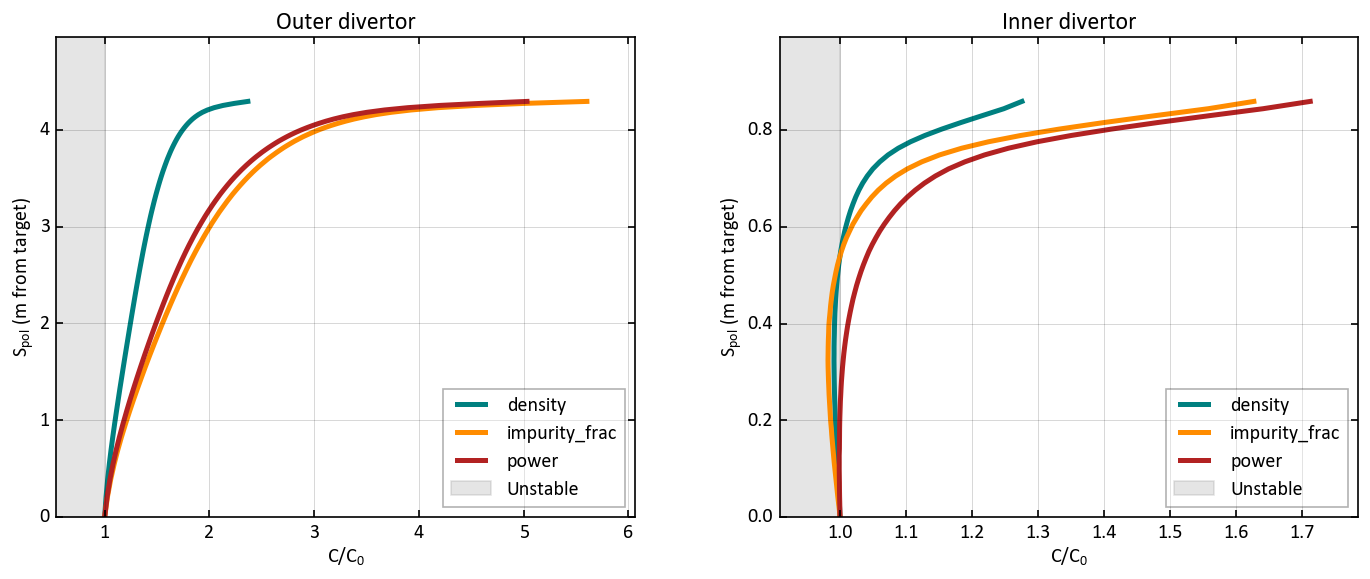

In [57]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)

sepadd = 0
fig, axes = plt.subplots(1,2, figsize = (14,5))
# fig.suptitle("Density scan of front profiles")
ax = axes[0]

basis = "crel"

for k, side in enumerate(["ol", "il"]):


    for i, cvar in enumerate(["density", "impurity_frac", "power"]):
        
        o = store[sepadd][cvar][side].copy()
        x = o[basis]        
        if cvar == "power":
            x = 1/x
        axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 0, linewidth = 3,  color = colors[i], label = cvar)


for ax in axes:
    
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    
    ylims = ax.get_ylim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C/C_{0}$")
    # ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    # ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

# Paper fluctuation plot

C:\Users\mikek\AppData\Local\Temp\ipykernel_42016\79853154.py:117: UserWarning: FixedFormatter should only be used together with FixedLocator
  parax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, 1, 2, 3, 4]))
C:\Users\mikek\AppData\Local\Temp\ipykernel_42016\79853154.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  parax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, 4, 12, 18]))


Text(0.705, 1, 'Outer divertor')

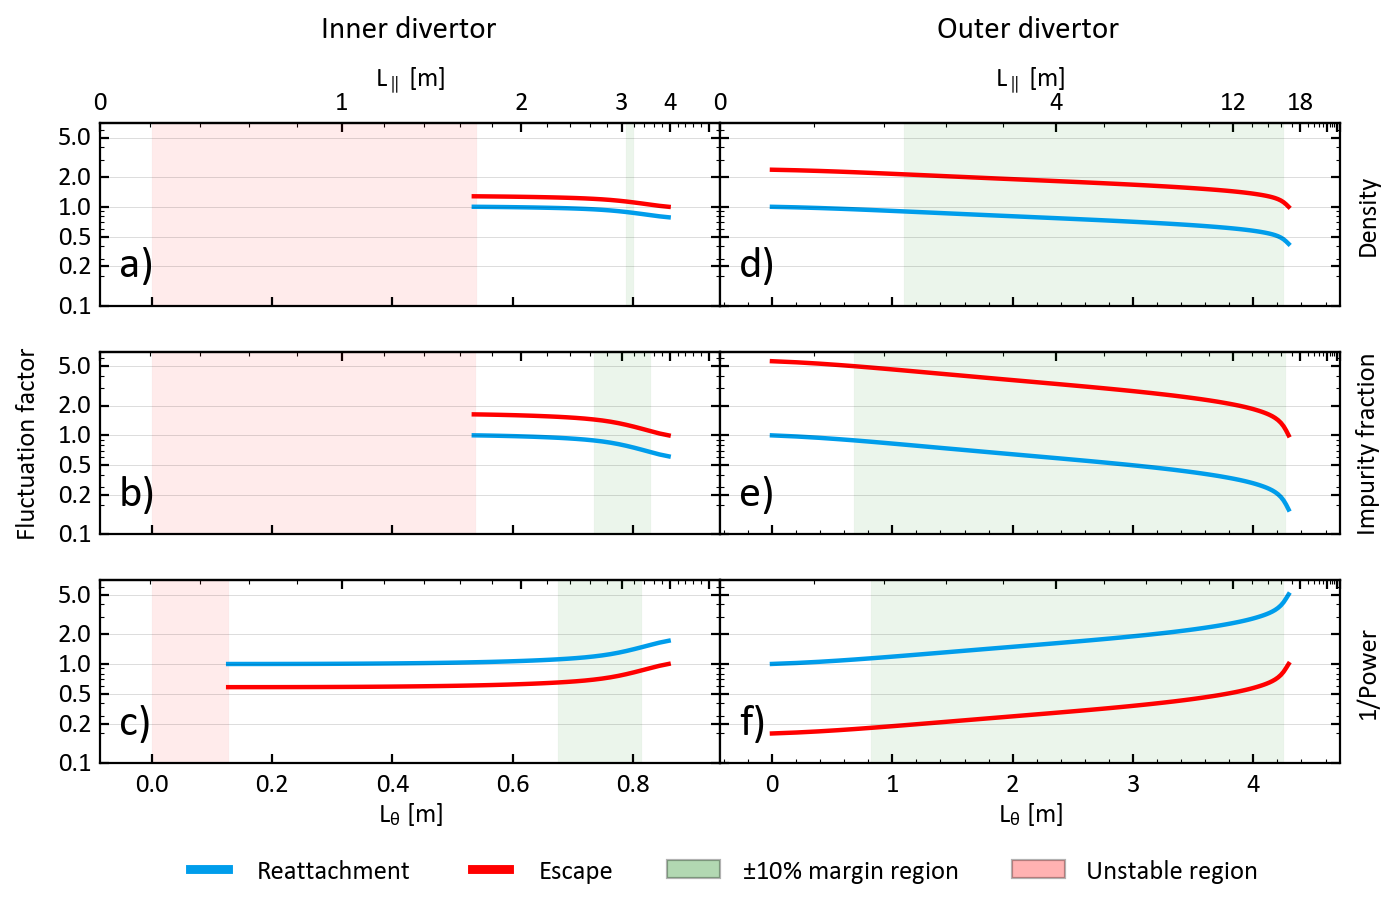

In [16]:
fig, axeses = plt.subplots(3,2, figsize = (10, 5), dpi = 160, sharex = False)
make_line_plot(axeses[:,0], "il")
make_line_plot(axeses[:,1], "ol", set_titles = False)

for ax in axeses[:2, :].flatten():
    ax.set_xticklabels([])
    
for ax in axeses[:, 1].flatten():
    ax.set_yticklabels([])
    ax.set_ylabel("")
    
labelpad = 7
axeses[0,1].set_ylabel("Density", labelpad = labelpad)
axeses[1,1].set_ylabel("Impurity fraction", labelpad = labelpad)
axeses[2,1].set_ylabel(r"1/Power", labelpad = labelpad)

for ax in axeses[:,1].flatten():
    ax.yaxis.set_label_position("right")
    
titles = ["a)", "d)", "b)", "e)", "c)", "f)"]
for i, ax in enumerate(axeses.flatten()):
    ax.set_ylim(0.1,7)
    ax.set_title(titles[i], y=0.10, x = 0.03, loc = "left", fontsize= 20)

    
fig.subplots_adjust(wspace = 0)

legend_elements = [
    mpl.lines.Line2D([0], [0], lw = 4, color="#009DEB", label='Reattachment'),
    mpl.lines.Line2D([0], [0], lw = 4, color="#FF0000", label='Escape'),
    # mpl.patches.Patch(facecolor = "darkorange", alpha = 0.3, hatch = "", edgecolor = "k", label = "$\pm$5% margin"),
    mpl.patches.Patch(facecolor = "green", alpha = 0.3, hatch = "", edgecolor = "k", label = "$\pm$10% margin region"),
    mpl.patches.Patch(facecolor = "red", alpha = 0.3, hatch = "", edgecolor = "k", label = "Unstable region")
]

ax.legend(handles = legend_elements, framealpha = 1, ncols = 4, loc = "lower center", bbox_to_anchor = (0, -0.8), edgecolor = "None")

fig.text(0.318, 1, "Inner divertor", horizontalalignment = "center", verticalalignment = "bottom", fontsize = 14)
fig.text(0.705, 1, "Outer divertor", horizontalalignment = "center", verticalalignment = "bottom", fontsize = 14)

In [7]:
plt.style.use(r"C:\Users\mikek\OneDrive\Project\python-packages\matplotlib_styles\mike.mplstyle")
side = "ol"
cvar = "density"
sepadd = 0



def make_line_plot(axes, side, set_titles = True, fontsize = 12):

    # dashes = ["solid", "dashed", "dashdot"]
    titles = [r"$n_{u}$", r"$c_{Ar}$", r"$q_{\parallel}$"]
    for i, cvar in enumerate(["density", "impurity_frac", "power"]):
        o = store[sepadd][cvar][side]
        crel = 1/o["crel"] if cvar == "power" else o["crel"]
        # crel = o["crel"]
        ax = axes[i]
        # margin1 = abs((crel[0] - crel)/crel)
        # margin2 = abs((crel[-1] - crel)/crel)
        # 
        x = np.array(o["SpolPlot"])
        
        margin1 = abs((crel[0]/crel))
        margin2 = abs((crel[-1]/crel))

        df = pd.DataFrame()
        df["x"] = o["SpolPlot"]
        df["reattachment"] = margin1
        df["escape"] = margin2

        zone_5pc = df.query("reattachment < 0.95 and escape > 1.05")
        zone_10pc = df.query("reattachment < 0.90 and escape > 1.1")
        
        fillalpha = 0.08
        
        # ax.fill_between(
        #     [zone_5pc["x"].iloc[0],
        #     zone_10pc["x"].iloc[0]],
        #                 y1 = 1e-3, y2 = 10, color = "darkorange", alpha = fillalpha, label = "5%", hatch = "", edgecolor = "k", linewidth = 0.1)
        
        # ax.fill_between(
        #     [zone_5pc["x"].iloc[-1],
        #     zone_10pc["x"].iloc[-1]], 
        #                 y1 = 1e-3, y2 = 10, color = "darkorange", alpha = fillalpha, label = "5%", hatch = "", edgecolor = "k", linewidth = 0.1)
        
        ax.fill_between(
            [zone_10pc["x"].iloc[0],
            zone_10pc["x"].iloc[-1]], 
                        y1 = 1e-3, y2 = 10, color = "green", alpha = fillalpha, label = "10%", hatch = "", edgecolor = "k", linewidth = 0.1)
        
        
        
        # Plot unstable region
        if "i" in side:
            unstable = get_unstable_region(store, side, cvar = cvar)
            ax.fill_between(
                [unstable[0],
                unstable[1]], 
                            y1 = 1e-3, y2 = 10, color = "red", alpha = fillalpha, label = "10%", hatch = "", edgecolor = "k", linewidth = 0.1)

        
            first_stable = np.argmin(np.abs(x-unstable[1]))
        else:
            first_stable = 0


        y1 = margin1[first_stable:]
        y2 = margin2[first_stable:]
        if cvar == "power":
            y1 = 1/y1
            y2 = 1/y2
            
        ax.plot(x[first_stable:], y1, label = "Reattachment", color = "#009DEB")
        ax.plot(x[first_stable:], y2, label = "Escape", color = "#FF0000")
        

        ## Titles/labels
        # if i == 0: ax.legend(loc="upper center", ncols=4, framealpha = 1, bbox_to_anchor=(0.5, 1.7))
        if set_titles: ax.set_title(titles[i], y=0.1, x = 0.02, fontsize = fontsize, loc = "left")
        
        
        ## Grid
        ax.grid(axis = "x", which = "both", visible = False)
        ax.grid(axis = "y", which = "major", visible = True)
        ax.grid(axis = "y", which = "minor", visible = False)


        
        ## Y axis
        ax.set_yscale("log")
        # ax.yaxis.set_major_locator(mpl.ticker.FixedFormatter([0.01, 0.1, 1, 3]))
        ax.set_yticks([0.1, 0.25, 0.5, 1, 2, 5])
        # ax.set_yticks([0, 0.1, 1, 5])
        ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
        if i == 1: ax.set_ylabel("Fluctuation factor", labelpad = 8, fontsize = fontsize)
        # ax.set_ylim(1, 2)
        
        
        ## X axis
        ax.xaxis.set_minor_locator(MultipleLocator(0.2))
        ax.tick_params(axis="x", which = "both", top=False)
        if i == 2: ax.set_xlabel(r"$L_{\theta}$ $[m]$", fontsize = fontsize)
        
        
        ## Secondary X axis
        # Provide function to translate from one to the other and back
        def pol2par(x):
            return np.interp(x, o["SpolPlot"], o["Splot"])

        def par2pol(x):
            return np.interp(x, o["Splot"], o["SpolPlot"])
        
        
        parax = ax.secondary_xaxis('top', functions = (pol2par, par2pol))
        
        if i == 0:
            if side == "il":
                parax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, 1, 2, 3, 4]))
            else:
                parax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, 4, 12, 18]))
            parax.set_xlabel("$L_{\parallel}$ $[m]$")
            
        else:
            parax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([]))
            
        parax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
        parax.tick_params(axis="x", which = "both", top = True)



# Only power


C:\Users\mikek\AppData\Local\Temp\ipykernel_70672\3670342436.py:127: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace = 0, hspace = 0.9)


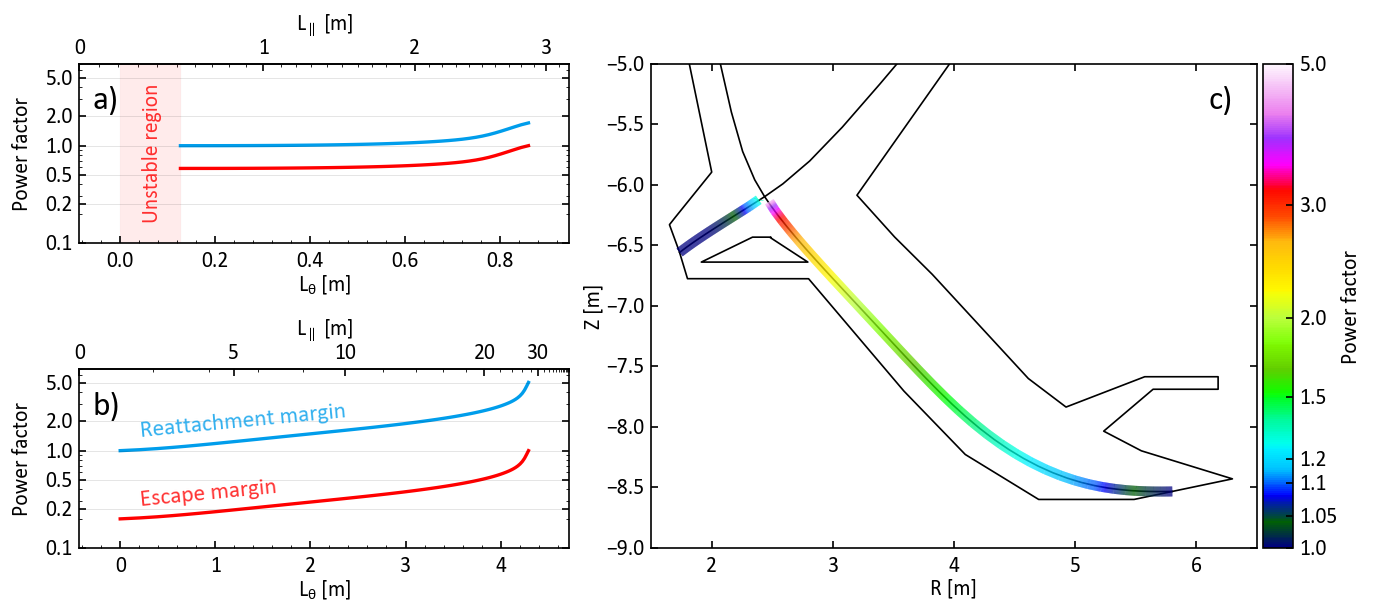

In [45]:
sepadd = 0 
cvar = "power"
fontsize = 13

# fig, axes = plt.subplots(2,1, figsize = (6,6), dpi = 160, sharex = False)

fig = plt.figure(layout = "constrained", figsize = (11,5))
axd = fig.subplot_mosaic(
    """
    AC
    BC
    """,
    width_ratios=[0.7,1])

for i, side in enumerate(["il", "ol"]):

    o = store[sepadd][cvar][side]
    crel = 1/o["crel"] if cvar == "power" else o["crel"]
    # crel = o["crel"]
    ax = axd[["A","B"][i]]
    # margin1 = abs((crel[0] - crel)/crel)
    # margin2 = abs((crel[-1] - crel)/crel)
    # 
    x = np.array(o["SpolPlot"])

    ## Calculate margins
    margin1 = abs((crel[0]/crel))
    margin2 = abs((crel[-1]/crel))

    df = pd.DataFrame()
    df["x"] = o["SpolPlot"]
    df["reattachment"] = margin1
    df["escape"] = margin2

    zone_5pc = df.query("reattachment < 0.95 and escape > 1.05")
    zone_10pc = df.query("reattachment < 0.90 and escape > 1.1")

    fillalpha = 0.08

    # Actual plot of 10% zone
    # ax.fill_between(
    #     [zone_10pc["x"].iloc[0],
    #     zone_10pc["x"].iloc[-1]], 
    #                 y1 = 1e-3, y2 = 10, color = "green", alpha = fillalpha, label = "10%", hatch = "", edgecolor = "k", linewidth = 0.1)



    ## Plot unstable region
    if "i" in side:
        unstable = get_unstable_region(store, side, cvar = cvar)
        ax.fill_between(
            [unstable[0],
            unstable[1]], 
                        y1 = 1e-3, y2 = 10, color = "red", alpha = fillalpha, label = "10%", hatch = "", edgecolor = "k", linewidth = 0.1)


        first_stable = np.argmin(np.abs(x-unstable[1]))
    else:
        first_stable = 0


    y1 = margin1[first_stable:]
    y2 = margin2[first_stable:]
    if cvar == "power":
        y1 = 1/y1
        y2 = 1/y2
        
    # Actual plot
    ax.plot(x[first_stable:], y1, label = "Reattachment", color = "#009DEB")
    ax.plot(x[first_stable:], y2, label = "Escape", color = "#FF0000")

    ## Grid
    ax.grid(axis = "x", which = "both", visible = False)
    ax.grid(axis = "y", which = "major", visible = True)
    ax.grid(axis = "y", which = "minor", visible = False)

    ## Y axis
    ax.set_yscale("log")
    ax.set_yticks([0.1, 0.25, 0.5, 1, 2, 5])
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
    ax.set_ylabel("Power factor", labelpad = 8, fontsize = fontsize)

    ## X axis
    if side == "ol":
        ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    else:
        ax.xaxis.set_minor_locator(MultipleLocator(0.04))
        
    ax.tick_params(axis="x", which = "both", top=False)
    ax.set_xlabel(r"$L_{\theta}$ $[m]$", fontsize = fontsize)

    ## Secondary X axis
    # Provide function to translate from one to the other and back
    def pol2par(x):
        return np.interp(x, o["SpolPlot"], o["Splot"])

    def par2pol(x):
        return np.interp(x, o["Splot"], o["SpolPlot"])


    parax = ax.secondary_xaxis('top', functions = (pol2par, par2pol))
    
    if side == "il":
        parax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0, 1, 2, 3, 4]))
        parax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    else:
        parax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0, 5, 10, 20, 30]))
        parax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
        
    parax.set_xlabel("$L_{\parallel}$ $[m]$", fontsize = fontsize, labelpad = 5)
    
    # parax.tick_params(axis="x", which = "minor", top = True)
    # parax.tick_params(axis="x", which = "major", top = True)
    
    ## Titles
    titles = ["a)", "b)"]
    for i, ax in enumerate([axd["A"], axd["B"]]):
        ax.set_ylim(0.1,7)
        # ax.set_title(titles[i], y=0.62, x = 0.03, loc = "left", fontsize= 20)
        
    ## Scale all tick labels
    
    parax.tick_params(labelsize = fontsize)
        
       
## Figure adjust 
fig.subplots_adjust(wspace = 0, hspace = 0.9)


## Legend
legend_elements = [
    mpl.lines.Line2D([0], [0], lw = 4, color="#009DEB", label='Reattachment'),
    mpl.lines.Line2D([0], [0], lw = 4, color="#FF0000", label='Escape'),
    # mpl.patches.Patch(facecolor = "green", alpha = 0.3, hatch = "", edgecolor = "None", label = "$\pm$10% margin region"),
    mpl.patches.Patch(facecolor = "red", alpha = 0.3, hatch = "", edgecolor = "None", label = "Unstable region")
]

# fig.legend(handles = legend_elements, framealpha = 1, 
#            ncols = 4, loc = "upper center",
#            bbox_to_anchor = (0.52, 0.0), edgecolor = "None",
#            fontsize = fontsize)

## Figure titles
fig.text(0.065, 0.82, "a)", horizontalalignment = "left", verticalalignment = "bottom", fontsize = 20)
fig.text(0.065, 0.31, "b)", horizontalalignment = "left", verticalalignment = "bottom", fontsize = 20)
fig.text(0.91, 0.82, "c)", horizontalalignment = "left", verticalalignment = "bottom", fontsize = 20)
fig.text(0.102, 0.64, "Unstable region", horizontalalignment = "left", verticalalignment = "bottom", 
         color = "red", alpha = 0.8, fontsize = 13,
         rotation = 90)

# 0.18, 0.8
# 0.18, 0.7
fig.text(0.10, 0.31, "Reattachment margin", horizontalalignment = "left", verticalalignment = "center", 
         color = "#009DEB", alpha = 0.8, fontsize = 14,
         rotation = 5.5)
fig.text(0.10, 0.19, "Escape margin", horizontalalignment = "left", verticalalignment = "center", 
         color = "#FF0000", alpha = 0.8, fontsize = 14,
         rotation = 5.5)
# fig.text(0.705, 1.15, "Outer divertor", horizontalalignment = "center", verticalalignment = "bottom", fontsize = 14)

## 2D plot
make_continuous_margin_plot(axd["C"],  fontsize = fontsize)

axd["A"].tick_params(labelsize = fontsize)
axd["B"].tick_params(labelsize = fontsize)

In [48]:
fig.savefig("DLS-SPR45-margin.svg", format = "svg", bbox_inches = "tight")

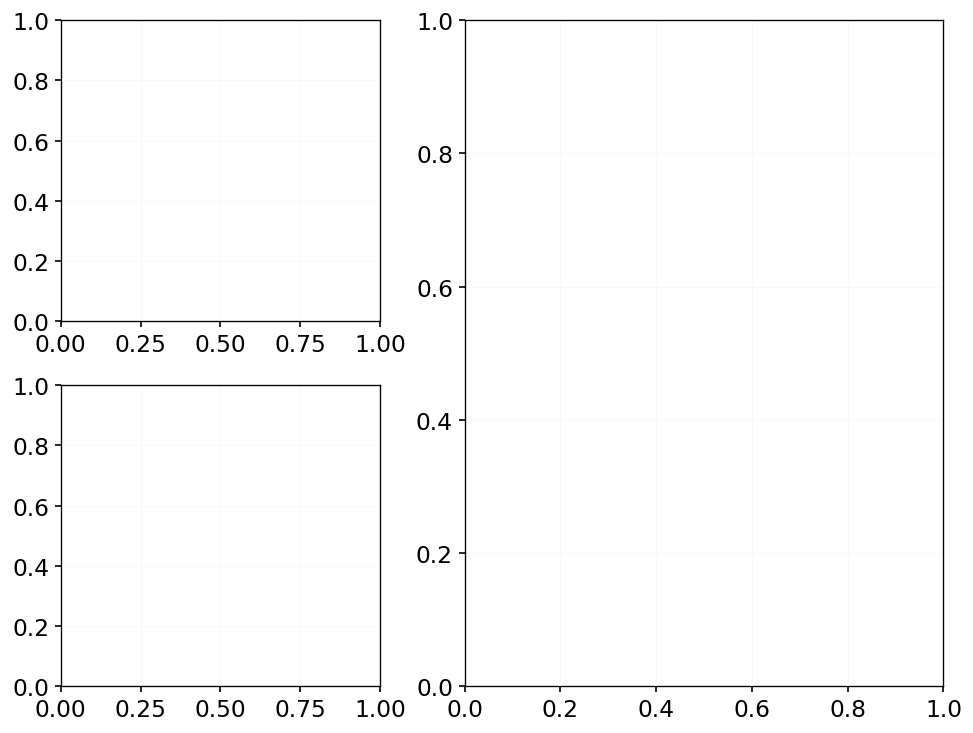

In [23]:

# identify_axes(axd)

In [24]:
axd.keys()

dict_keys(['A', 'C', 'B'])

## Single plot for testing

Crel is 1.30
Need crel of 1.71 to escape, therefore the factor you need to escape is 1.71 / 1.30 = 1.32
Need crel of 1.00 to reattach, therefore the factor you need to reattach is 1.00 / 1.30 = 0.77


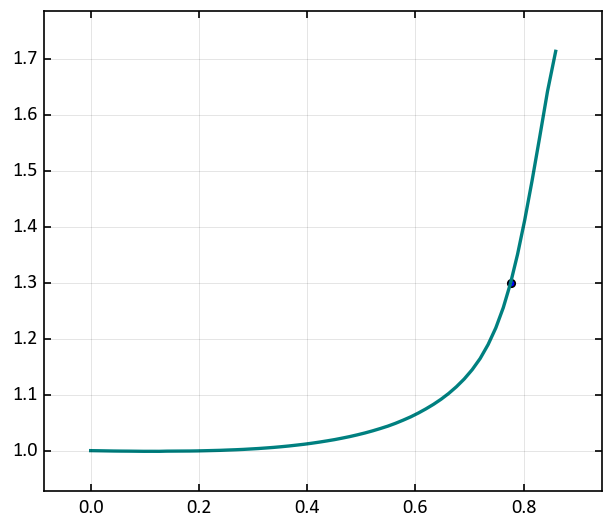

In [106]:
fig, ax = plt.subplots()
ax.plot(x, crel)
i = 50
ax.scatter(x[i], crel[i])
print(f"Crel is {crel[i]:.2f}")
print(f"Need crel of {crel[-1]:.2f} to escape, therefore the factor you need to escape is {crel[-1]:.2f} / {crel[i]:.2f} = {crel[-1]/crel[i]:.2f}")
print(f"Need crel of {crel[0]:.2f} to reattach, therefore the factor you need to reattach is {crel[0]:.2f} / {crel[i]:.2f} = {crel[0]/crel[i]:.2f}")
# ax.plot(x, margin
# plt.plot(crel)
# plt.plot(margin2)

NameError: name 'reattachment' is not defined

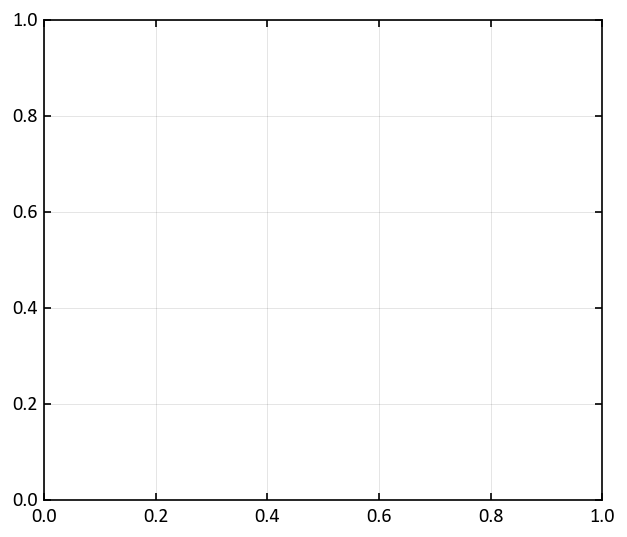

In [7]:
side = "il"
cvar = "density"
sepadd = 0

fig, ax = plt.subplots()

o = store[sepadd][cvar][side]
crel = 1/o["crel"] if cvar == "power" else o["crel"]

# margin1 = abs((crel[0] - crel)/crel)
# margin2 = abs((crel[-1] - crel)/crel)

margin1 = abs((crel[0] / crel))
margin2 = abs((crel[-1] / crel))


x = np.array(o["SpolPlot"])

df = pd.DataFrame()
df["x"] = o["SpolPlot"]
df["reattachment"] = margin1
df["escape"] = margin2

zone_5pc = df.query("reattachment < 0.95 and escape > 1.05")
zone_10pc = df.query("reattachment < 0.90 and escape > 1.1")

# ax.xaxis.set_minor_locator(MultipleLocator(2))

# MARGIN1: reattachment
# MARGIN2: escape



# 5% 
start1 = np.argmin(np.abs(reattachment - 0.95))
end1  = np.argmin(np.abs(escape - 1.05))
start1 = np.argmin(np.abs(reattachment - 0.90))
end1  = np.argmin(np.abs(escape - 1.1))

ax.fill_between(
    [zone_5pc["x"].iloc[0],
    zone_5pc["x"].iloc[-1]], 
                y1 = 1e-3, y2 = 2, color = "grey", alpha = 0.08, label = "5%", hatch = "\\\\", edgecolor = "k", linewidth = 0.1)

ax.fill_between(
    [zone_10pc["x"].iloc[0],
    zone_10pc["x"].iloc[-1]], 
                y1 = 1e-3, y2 = 2, color = "grey", alpha = 0.08, label = "10%", hatch = "//", edgecolor = "k", linewidth = 0.1)

unstable = get_unstable_region(store, "il", cvar = cvar)
ax.fill_between(
    [unstable[0],
    unstable[1]], 
                y1 = 1e-3, y2 = 2, color = "red", alpha = 0.08, label = "10%", hatch = "||", edgecolor = "k", linewidth = 0.1)


first_stable = np.argmin(np.abs(x-unstable[1]))

ax.plot(x[first_stable:], margin1[first_stable:], label = "Reattachment", color = "#009DEB")
ax.plot(x[first_stable:], margin2[first_stable:], label = "Escape", color = "#FF0000")
ax.xaxis.set_minor_locator(MultipleLocator(0.2))

ax.legend(loc="upper center", ncols=4, framealpha = 1, bbox_to_anchor=(0.5, 1.1))



ax.grid(which="minor", c = "k", alpha = 0.1, lw = 0.5)
ax.grid(which="major", c = "k", alpha = 0.4, lw = 0.5)
ax.grid(which="both", alpha = 0)
# ax.set_yscale("log")


ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
# ax.yaxis.set_minor_formatter(StrMethodFormatter("{x:.1}"))

ax.grid(axis = "y", which = "major", visible = True, alpha = 0.3)
ax.tick_params(axis="x", which = "both", top=False)

ax.set_ylim(0.6,1.5)

In [149]:
np.argmin(np.abs(margin1 - 0.95))

46

# RZ plot 

### Find minimum margins for each leg

In [5]:


sepadd = 0
zones = {}

for side in ["ol", "il"]:
    start = []
    end = []
    
    zones[side] = {}
    
    for i, cvar in enumerate(["density", "impurity_frac", "power"]):
        o = store[sepadd][cvar][side]
        crel = 1/o["crel"] if cvar == "power" else o["crel"]
        margin1 = abs((crel[0] - crel)/crel)
        margin2 = abs((crel[-1] - crel)/crel)

        x = o["SpolPlot"]
        lpar = o["Splot"]
        # ax.hlines(0.05, x[0], x[-1]*1.05, colors = "r", lw = 2, ls = "-", label = "5% fluctuation")
        start.append(x[np.where(margin1 > 0.05)[0][0]])
        end.append(x[np.where(margin2 < 0.05)[0][0]])
        
    # for i, _ in enumerate(start1):
    zones[side]["zone1"] = (max(start1), min(end1))
    zones[side]["zone2"] = (max(start2), min(end2))
    
    

        

NameError: name 'start1' is not defined

# SOLPS plot of safe zones

(0, 0.5400754315369345)

## SOLPS grid based plot

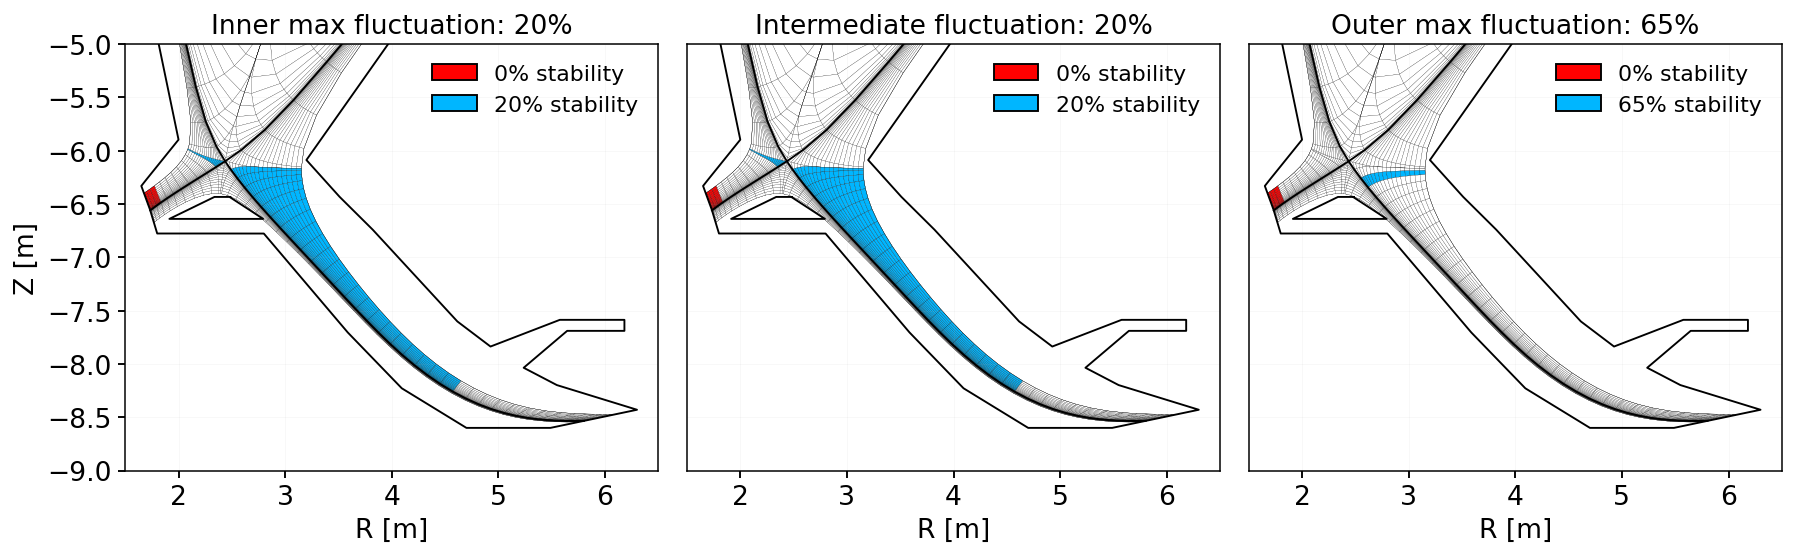

In [72]:
rwall, zwall = np.loadtxt(r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\spr45-2024-02-16.txt", unpack = True)
domeR = np.array([2486,2337,1914,2794,2486])
domeZ = np.array([6434,6434,6640,6640,6439])



scale = 1.1
fig, axes = plt.subplots(1,3, dpi = 150/scale, figsize = (12*scale, 4*scale), sharey = True)

fluctuations = [0.2, 0.2, 0.65]
# cvar = "power"

# fluctuations = [0.05, 0.2, 0.39]
cvar = "power"
dzone_s = make_dzones("ol", get_zone(store, "ol", fluctuations[0], cvar = cvar))
dzone_s += make_dzones("il", get_zone(store, "il", fluctuations[0], cvar = cvar))

dzone_m = make_dzones("ol", get_zone(store, "ol", fluctuations[1], cvar = cvar))
dzone_m += make_dzones("il", get_zone(store, "il", fluctuations[1], cvar = cvar))

dzone_l = make_dzones("ol", get_zone(store, "ol", fluctuations[2], cvar = cvar))

for zone in [dzone_s, dzone_m, dzone_l]:
    zone += make_dzones("il", get_unstable_region(store, "il", cvar = cvar), 0.5)
# dzone_l += make_dzones("il", get_zone(store, "il", 0.39))

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["white", "#FF0000", "#00B6FF"], N=3)
slc.plot_2d(param = f"Inner max fluctuation: {fluctuations[0]*100:.0f}%", data = dzone_s, ax = axes[0], fig = fig, 
            linewidth = 0.1, antialias = True, grid_only = False, vmax = 1,
            custom_cmap = cmap, cbar = False, axis_labels = False)

slc.plot_2d(param = f"Intermediate fluctuation: {fluctuations[1]*100:.0f}%", data = dzone_m, ax = axes[1], fig = fig, 
            linewidth = 0.1, antialias = True, grid_only = False, vmax = 1,
            custom_cmap = cmap, cbar = False, axis_labels = False)

slc.plot_2d(param = f"Outer max fluctuation: {fluctuations[2]*100:.0f}%", data = dzone_l, ax = axes[2], fig = fig, 
            linewidth = 0.1, antialias = True, grid_only = False, vmax = 1,
            custom_cmap = cmap, cbar = False, axis_labels = False)

wallw = 1

labels = [f"{fluctuations[0]*100:.0f}%", f"{fluctuations[1]*100:.0f}%", f"{fluctuations[2]*100:.0f}%"]


for i, ax in enumerate(axes):
    ax.plot(np.array(rwall), np.array(zwall), color = "black", lw = wallw)
    ax.plot(domeR/1000, -domeZ/1000, color = "black", lw = wallw)

    ax.set_aspect("equal")

    ax.set_xlim(1.5, 6.5)
    ax.set_ylim(-9, -5)
    ax.set_xlabel("R [m]")
    
    if i == 0: ax.set_ylabel("Z [m]")
    if i != 0: ax.tick_params(axis = "y", left = False)
    
    legend_elements = [
                   mpl.patches.Patch(facecolor='#FF0000', edgecolor='k', label='0% stability'),
                   mpl.patches.Patch(facecolor='#00B6FF', edgecolor='k', label=f'{labels[i]} stability')]

    ax.legend(handles=legend_elements, loc='upper right', fontsize = "small", framealpha = 0)
    
fig.subplots_adjust(wspace=0)
fig.tight_layout()


# SOLPS plot with continuous margin

In [12]:
See above

In [79]:
dfi_i

,R,Z,Lpol,crel,margin_t,margin_x
0,1.734862,-6.560044,0.000000,1.000000,1.000000,1.349119
1,1.738113,-6.557499,0.004128,0.999941,1.000059,1.349198
2,1.741381,-6.554977,0.008256,0.999882,1.000118,1.349278
3,1.744653,-6.552460,0.012385,0.999823,1.000177,1.349357
4,1.747925,-6.549943,0.016513,0.999758,1.000242,1.349446
...,...,...,...,...,...,...
187,2.377498,-6.132784,0.771978,1.286265,0.777445,1.048865
188,2.380899,-6.130444,0.776106,1.299922,0.769277,1.037846
189,2.384300,-6.128104,0.780234,1.316321,0.759693,1.024916
190,2.387701,-6.125764,0.784363,1.332720,0.750345,1.012305


Text(0, 0.5, 'Z [m]')

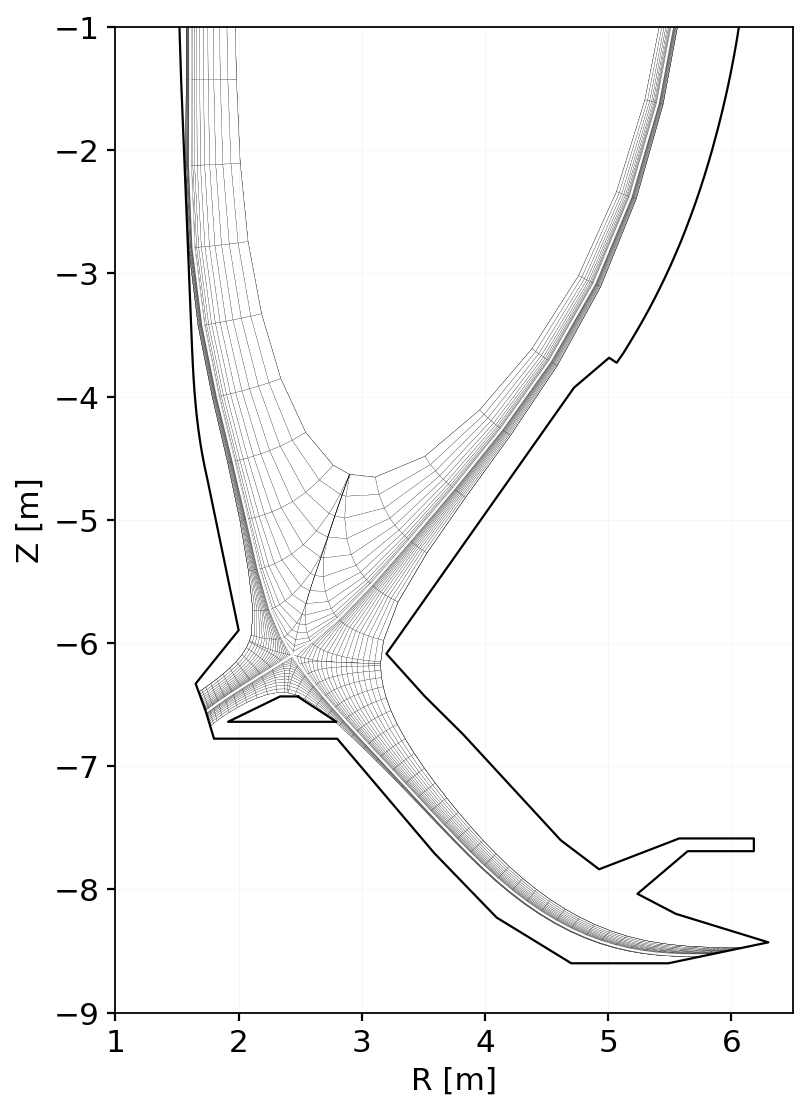

In [11]:
rwall, zwall = np.loadtxt(r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\spr45-2024-02-16.txt", unpack = True)
domeR = np.array([2486,2337,1914,2794,2486])
domeZ = np.array([6434,6434,6640,6640,6439])

fig, ax = plt.subplots(dpi = 160, figsize = (6,8), sharey = True)

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["white", "#FF0000", "#00B6FF"], N=3)
slc.plot_2d(param = f"",  ax = ax, fig = fig, 
            linewidth = 0.1, antialias = True, grid_only = True, vmax = 1,
            custom_cmap = cmap, cbar = False, axis_labels = False)


ax.plot(np.array(rwall), np.array(zwall), color = "black", lw = 1)
ax.plot(domeR/1000, -domeZ/1000, color = "black", lw = 1)
ax.set_aspect("equal")
ax.set_xlim(1.0, 6.5)
ax.set_ylim(-9, -1)
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")

## Put DLS geom in dataframe

In [89]:
dfs = {}

for side in ["ol", "il"]:
    dfs[side] = pd.DataFrame()
    for key in ["R", "Z", "Spol", "S"]:
        dfs[side][key] = eqb[sepadd][side][key]
        

## Use wall_details

start
start


Text(0, 0.5, 'Z [m]')

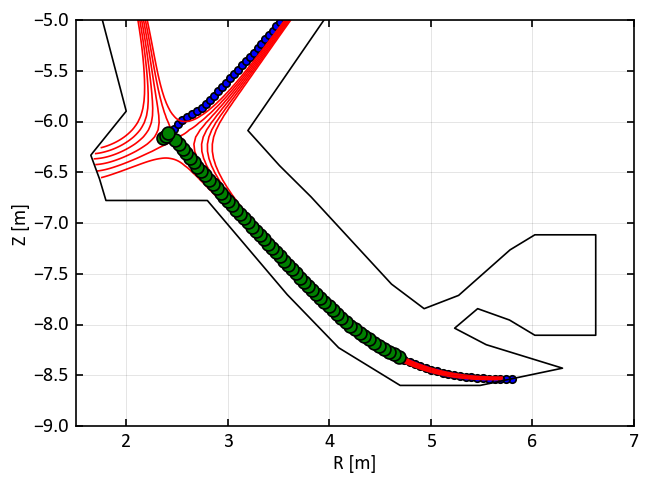

In [95]:
fig, ax = plt.subplots()

self = wall_details(
    # gfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\AH_PI4_P5.geqdsk",
    gfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\AH_PI4_P5-LATEST.geqdsk",
    wfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\SPR45.txt",
    monoblock = {"g":0.5e-3,"l":2e-3,"h":0.3e-3,"p":0.028},
    debug = True,
    fig = fig,
    ax = ax,
    custom_plot = True
)


def get_zone(side, zone):
    zone = zones[side][f"zone{zone}"]
    return dfs[side].query(f"S > {zone[0]} and S < {zone[1]}")

# ax.scatter(RZ[0], RZ[1])

ax.scatter(df["R"],df["Z"])

outer = get_zone("ol", 2)
ax.scatter(outer["R"], outer["Z"], zorder = 100, c = "green", s = 60)

inner = get_zone("il", 1)
ax.scatter(inner["R"], inner["Z"], zorder = 100, c = "green", s = 60)

ax.set_xlim(1.5, 7)
ax.set_ylim(-9, -5)
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")



In [ ]:
RZ = (2.6, -6.1)

df = pd.DataFrame()
df["R"], df["Z"], df["lpar"] = self.follow_fieldline(RZ[0], RZ[1], 0.1, stop_r = 5.56)
df["lpar"] = df["lpar"][::-1]   # 0 is target



## Plot zone

Text(0, 0.5, 'Z [m]')

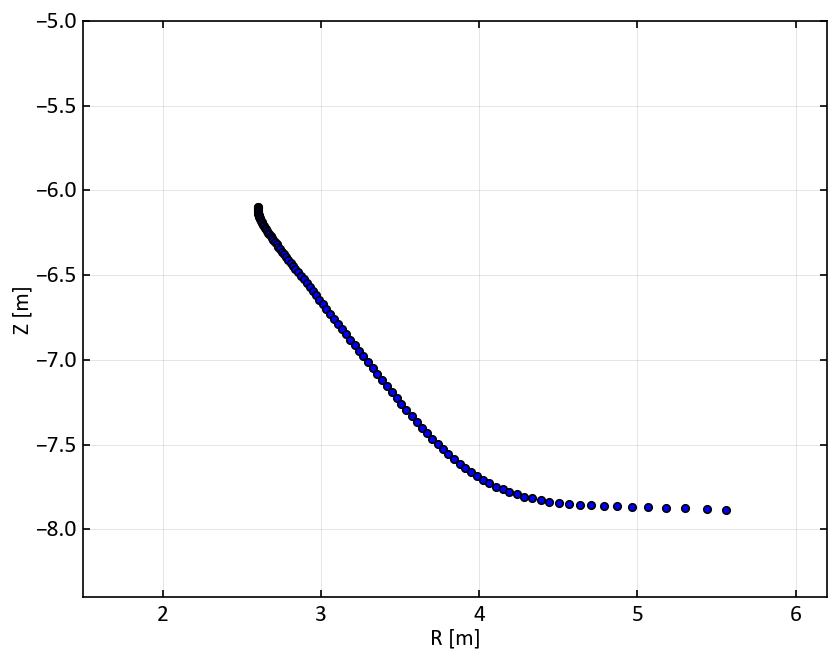

### SPR_wall

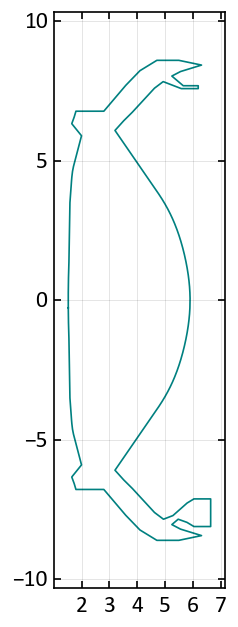

In [37]:
from SPR_wall import SPR_wall


wall = SPR_wall()
wall.SPR45new()

fig, ax = plt.subplots()

ax.plot(wall.R, wall.Z, linewidth = 1)
ax.set_aspect("equal")

array([       nan, 0.21189553, 0.3884783 , 0.5298271 , 0.63533449,
       0.70721373, 0.74383578, 0.77783471, 0.81074589, 0.84642993])

# Compare SOL ring flux expansion

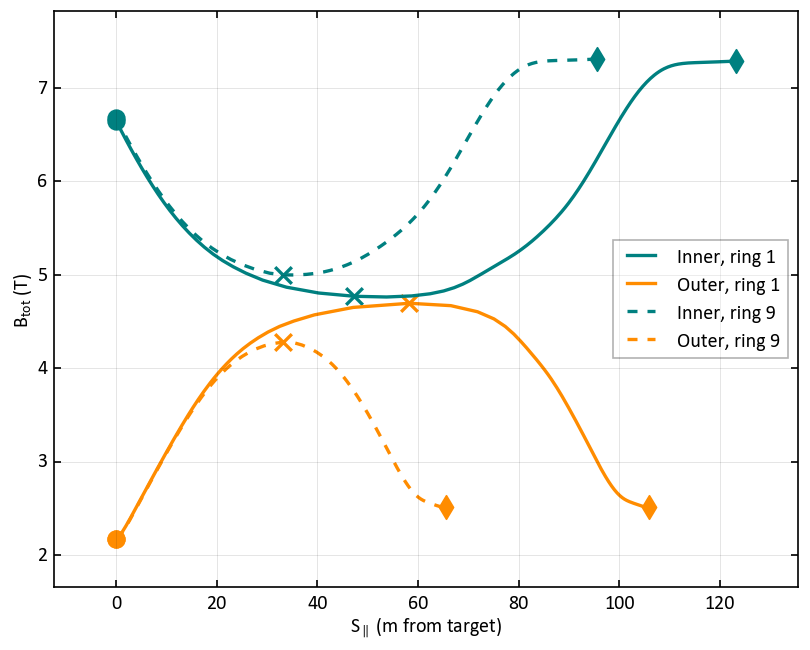

In [106]:
fig, ax = plt.subplots(dpi = 120, figsize = (8,6))
colors = mike_cmap(2)
labels = {"ol":"Outer", "il":"Inner"}
lstyles = ["-", "--"]
size = 100

for sepid, sepadd in enumerate([1,9]):
    for i, side in enumerate(["il", "ol"]):
        d = eqb[sepadd][side]
        Xpoint = d["Xpoint"]
        ax.plot(d["S"], d["Btot"], color = colors[i], label = labels[side] + f", ring {sepadd}", ls = lstyles[sepid])
        ax.scatter(d["S"][Xpoint], d["Btot"][Xpoint], color = colors[i], marker = "x", s = size)
        ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o", s = size)
        ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d", s = size)

ax.set_xlabel("$S_{\parallel}$ (m from target)")
ax.set_ylabel("$B_{tot}$ (T)")
ax.legend()

# h,l = ax.get_legend_handles_labels()
# extra_handles = [
#     mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
#     mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
#     mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, 
        #   handles = h+extra_handles
          )

# Plot basic results

Text(0.5, 1.0, 'Inner divertor')

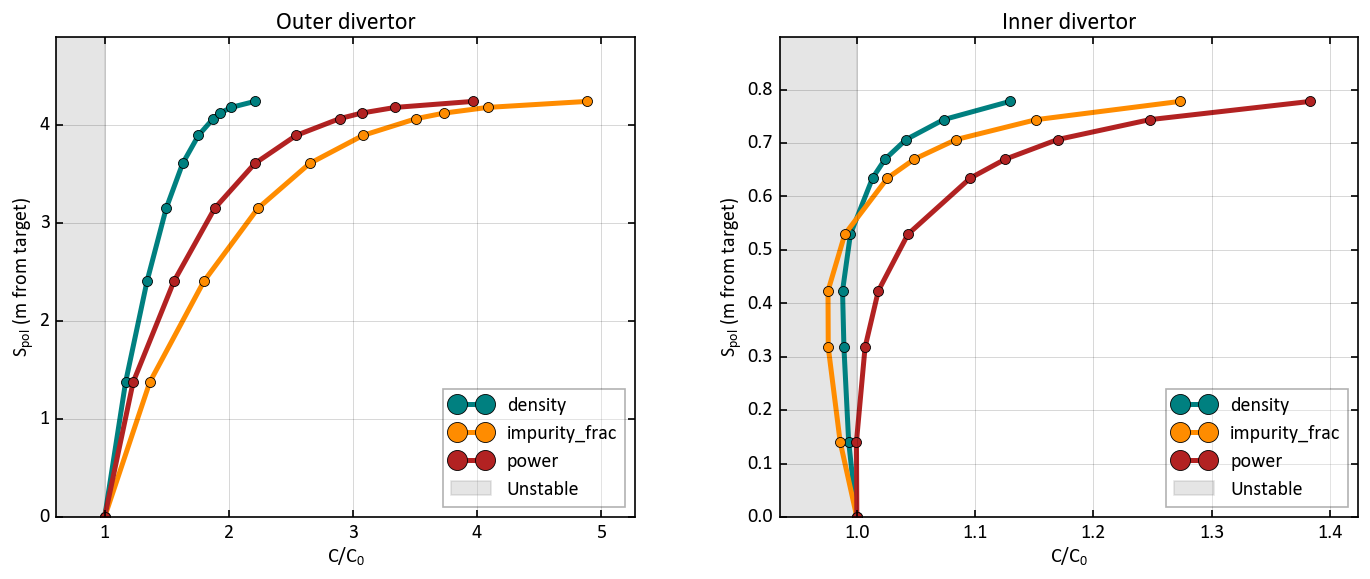

In [90]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)
cvar = "impurity_frac"
fig, axes = plt.subplots(1,2, figsize = (14,5))
# fig.suptitle("Density scan of front profiles")
ax = axes[0]

basis = "crel"
sepadd = 1

for k, side in enumerate(["ol", "il"]):


    for i, cvar in enumerate(["density", "impurity_frac", "power"]):
        
        o = store[sepadd][cvar][side].copy()
        x = o[basis]        
        if cvar == "power":
            x = 1/x
        axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 6, linewidth = 3,  color = colors[i], label = cvar)


for ax in axes:
    
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    
    ylims = ax.get_ylim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C/C_{0}$")
    # ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    # ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

# Safety margin

(-0.1, 0.5)

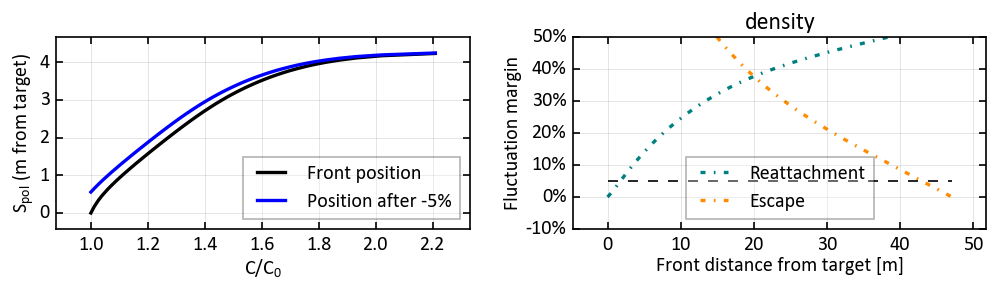

In [72]:
plt.style.use(r"C:\Users\mikek\OneDrive\Project\python-packages\matplotlib_styles\mike.mplstyle")
side = "ol"
cvar = "density"

o = store[cvar][side].copy()
d = eqb["SPR45_new"][side].copy()
# crel = o["cvar"]
crel = 1/o["crel"] if cvar == "power" else o["crel"]
# crel -= 1

base_spol = interpolate.interp1d(crel, o["SpolPlot"], kind = "cubic")
negative_spol = interpolate.interp1d(crel-0.05, o["SpolPlot"], fill_value="extrapolate", kind = "cubic")

negative = [negative_spol(x) for x in crel]

fig, axes = plt.subplots(1,2, figsize = (10,2), dpi = 120)
ax = axes[0]
ax.plot(crel, o["SpolPlot"], color = "black", label = "Front position")
# ax.plot(o["crel"], [base_spol(x) for x in o["crel"]], color = "black", label = "Front position")
ax.plot(crel, negative, label = "Position after -5%", color = "blue")
# ax.plot(o["crel"]+0.05, o["SpolPlot"], label = "Position after +5%", color = "red")
ax.set_xlabel("$C / C_{0}$")
ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
ax.legend()


ax = axes[1]

dashes = ["solid", "dashed", "dashdot"]
# for i, cvar in enumerate(["density", "impurity_frac", "power"]):
# o = store[cvar]["ou"]

margin1 = abs((crel[0] - crel)/crel)
margin2 = abs((crel[-1] - crel)/crel)

x = o["Splot"]
ax.plot(x, margin1, label = "Reattachment", ls = dashes[i])
ax.plot(x, margin2, label = "Escape", ls = dashes[i])
# ax.plot((crel[-1] - crel)/crel, o["SpolPlot"], color = "black", label = "Allowable cvar increase before escape")

ax.hlines(0.05, x[0], x[-1], colors = "k", lw = 1, ls = "--")

ax.legend()
ax.set_title(f"{cvar}")
ax.set_xlabel("Front distance from target [m]")
ax.set_ylabel("Fluctuation margin")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_ylim(-0.1,0.5)